Single qubit errors validated against Egan paper
========================================

This is a simulation of single qubit errors in an ion trap quantum computer to compare the Qiskit noise model with experiments by Egan [1].  The noise model will be used on a simulation of the Steane code.

This simulation uses the randomised benchmark function from Qiskit to simulate Egan's characterization of single qubit errors.  A circuit is constructed with N-1 sequential random Clifford gates and a final Clifford gate that inverts the others.  In the circuit diagram below the Clifford gates are separated by a barrier.

The circuit is transpiled into the native ion computer gate set before computing the noise.

With no noise the qubit will always finish in the starting |0> ground state.  A simulation was run and the ground state population is shown plotted against the number of Clifford gates.  For comparison a calculation of the expected ground state population using a error per Clifford gate of 3.4(8)×10−4 as quoted by Egan is plotted.

We use a depolarising error with a parameter which represents the chance that a X, Y, Z and I error occurs.  Since a Z and I error won't be detectable we have doubled Egan's stated error of 1.8(3)×10−4 per native Pauli gate to use 3.66 1.8(3)×10−4 as the depolarising error parameter.

Egan shows two results for the fidelity per Clifford gate, an upper bound for the 1 ion chain, and a lower bound for the less accurate but more realistic 15 ion chain.  Egan's upper bound for the 1 ion chain is 0.990(3) and the lower bound from the 15 ion chain is 0.988(0).  The simulation shows 0.9877, slightly below Egan's lower band.  It should be noted that the simulations are random, and some noise is inevitable.  The single gate error is not a key parameter.  It is an order of magnitude less that the two gate error and is often neglected in simulations by other workers. 

The intercept on the y axis in our simulation is 0.995.  This is in agreement with Egan's results and shows that 0.046 is a reasonable parameter for the measure noise.

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

# Import the randomized benchmarking Function and other qiskits modules
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

import random
import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    get_noise, 
    mean_of_list,
    calculate_standard_error
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

SHOTS = 10000                            #Number of shots to run 
ITERATIONS = 25                          #Number of iterations for each simulation
MEASURE_NOISE = 0.0046                   #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366      #Parameter for single gate depolarising channel
TWO_GATE_DEPOLARISING = 0.0              #Two gate noise not relevant
SINGLE_CLIFFORD_GATE_NOISE = 0.000348    #Used for calculation
NOISE = True                             #Test with noise?

SIMULATION_GATE_DEPTH_LIST = [1, 3, 7, 11, 15, 19]  #Number of Clifford gate for simulation
CALCULATION_GATE_DEPTH_LIST = [0, 4, 6, 8, 12, 16, 20]  #Number of Clifford gate for calculations

SIMULATOR = Aer.get_backend('qasm_simulator')

Set up circuits in a list.

In [3]:
# Generate randomised benchmark circuit 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = SIMULATION_GATE_DEPTH_LIST
# Number of seeds (random sequences)
rb_opts['nseeds'] = ITERATIONS
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

Draw an example of random circuit for eight Clifford gates.

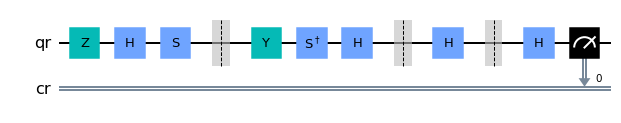

In [4]:
rb_circs[0][1].draw(output = 'mpl', filename = 'Single_Clifford_gates_circuit.jpg', fold = 60)

Transpile the circuit and draw the equivalent transpiled circuit.

In [5]:
qt = transpile(rb_circs[0][1], basis_gates = BASIS_GATE_SET)

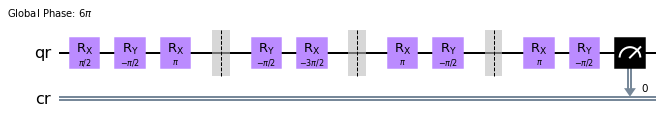

In [6]:
qt.draw(output = 'mpl', filename = 'Single_Clifford_gates_circuit_transpiled.jpg', fold = 30)

In [7]:
noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET)

In [8]:
# initialise lists for graphs
mean_probability = []
standard_error_list = []
number_of_gates_simulation = []

loop_number = 0
for gate_depth in SIMULATION_GATE_DEPTH_LIST:
    simulation_probability = []
    for iteration in range(ITERATIONS):
        qt = transpile(rb_circs[iteration][loop_number], basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots=SHOTS).result()     
        counts = result.get_counts(qt)
        probability = counts.get('0') / SHOTS
        simulation_probability.append(probability)      
    number_of_gates_simulation.append(gate_depth + 1)
    # need to add one gate to allow for the reversal
    mean = mean_of_list(simulation_probability)
    mean_probability.append(mean)
    standard_deviation, standard_error = calculate_standard_error(simulation_probability)
    standard_error_list.append(standard_error)
    true_gate_depth = (gate_depth + 1)    
    print(f'For {true_gate_depth} gates mean simulated ground state population probability is {mean:.4f}')
    print(f'The standard error is {standard_error:.4f}')
    loop_number = loop_number + 1

For 2 gates mean simulated ground state population probability is 0.9947
The standard error is 0.0002
For 4 gates mean simulated ground state population probability is 0.9937
The standard error is 0.0001
For 8 gates mean simulated ground state population probability is 0.9919
The standard error is 0.0002
For 12 gates mean simulated ground state population probability is 0.9903
The standard error is 0.0002
For 16 gates mean simulated ground state population probability is 0.9883
The standard error is 0.0002
For 20 gates mean simulated ground state population probability is 0.9869
The standard error is 0.0003


Calculations

In [9]:
theoretical_probability = []
egan_one_ion_noise = []
egan_fifteen_ion_noise = []
number_of_gates_calculation = []

for gate_depth in CALCULATION_GATE_DEPTH_LIST:
    gate_noise = ((1 - SINGLE_CLIFFORD_GATE_NOISE) ** gate_depth) 
    theory = gate_noise * (1 - MEASURE_NOISE)  
    egan_one_ion = 0.99388 - gate_depth * 0.000177
    egan_fifteen_ion = 0.9951 - gate_depth * 0.000348
    theoretical_probability.append(theory)
    egan_one_ion_noise.append(egan_one_ion)
    egan_fifteen_ion_noise.append(egan_fifteen_ion)
    number_of_gates_calculation.append(gate_depth) 
    
    print(f'For gate_depth {gate_depth}')  
    print(f'The best fit line for Egan 1 ion chain is {egan_one_ion:.4f} and for Egan 15 ion chain is {egan_fifteen_ion:.4f}')
    print(f'A calculation based on the number of Clifford gates gives {theory:.4f}')   

For gate_depth 0
The best fit line for Egan 1 ion chain is 0.9939 and for Egan 15 ion chain is 0.9951
A calculation based on the number of Clifford gates gives 0.9954
For gate_depth 4
The best fit line for Egan 1 ion chain is 0.9932 and for Egan 15 ion chain is 0.9937
A calculation based on the number of Clifford gates gives 0.9940
For gate_depth 6
The best fit line for Egan 1 ion chain is 0.9928 and for Egan 15 ion chain is 0.9930
A calculation based on the number of Clifford gates gives 0.9933
For gate_depth 8
The best fit line for Egan 1 ion chain is 0.9925 and for Egan 15 ion chain is 0.9923
A calculation based on the number of Clifford gates gives 0.9926
For gate_depth 12
The best fit line for Egan 1 ion chain is 0.9918 and for Egan 15 ion chain is 0.9909
A calculation based on the number of Clifford gates gives 0.9913
For gate_depth 16
The best fit line for Egan 1 ion chain is 0.9910 and for Egan 15 ion chain is 0.9895
A calculation based on the number of Clifford gates gives 0.9

Plot graph:

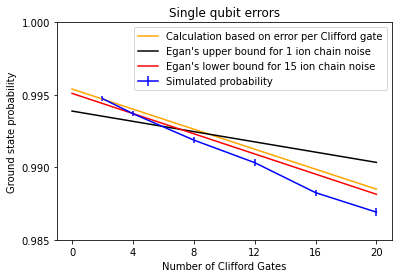

In [10]:
#graph constants
YMIN = 0.985
YMAX = 1.000
YTICK = 0.005

#graph
title_text = "Ground state probabilty against number of Clifford Gates"
#plt.scatter(number_of_gates_simulation, simulation_probability, label = "Simulation results" )
#plt.plot(number_of_gates_simulation, mean_probability, label = "Simulated probabilty" , color="blue")
plt.errorbar(number_of_gates_simulation, mean_probability, yerr = standard_error_list,
              label = "Simulated probability" , color="blue")
plt.plot(number_of_gates_calculation, theoretical_probability, label = "Calculation based on error per Clifford gate" , color="orange")
plt.plot(number_of_gates_calculation, egan_one_ion_noise, label = "Egan's upper bound for 1 ion chain noise" , color="black")
plt.plot(number_of_gates_calculation, egan_fifteen_ion_noise, label = "Egan's lower bound for 15 ion chain noise" , color="red")
plt.title('Single qubit errors')
plt.xlabel('Number of Clifford Gates')
plt.ylabel('Ground state probability')  
plt.legend()
plt.ylim(YMIN, YMAX)
plt.xticks(np.arange(0, 21, 4))
plt.yticks(np.arange(YMIN, YMAX, YTICK))
fname = "Single_Clifford_gate_errors_graph.png"
plt.savefig(fname)

In the graph above the offset corresponds to the state preparation and measurement (SPAM) error of 0.0046 reported by Egan.

The slope gives the error per Clifford gate.  Since the error is small the graph is approximated linear.

For comparise actual Egan's results are shown below.

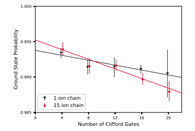